 # 0.0 Imports

In [ ]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import xgboost  as xgb
import inflection
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn  import preprocessing   as pp
from sklearn  import ensemble        as en
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics  import  mean_absolute_error, mean_squared_error
from catboost         import CatBoostRegressor
from lightgbm         import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn  import model_selection as ms
from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [74]:
def scale_standard(df, columns,ss):
    df[columns] = ss.fit_transform(df[columns].values)
    return df
     
def rescalin_mms_train(df, columns_minmax,mms):        
    for column in columns_minmax:
        df[column] = mms.fit_transform(df[[column]].values)
    return df

def scale_standard_test(df, columns, ss):
    df[columns] = ss.transform(df[columns].values)
    return df

def rescaling_mms_test(df, columns_minmax, mms_dict):
    for column in columns_minmax:
        df[column] = mms.transform(df[[column]].values)
    return df

def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 8]
    plt.rcParams['font.size'] = 12
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)


## 0.2 Loading Datasets

In [5]:
df0 = pd.read_csv('datasets/train.csv')
d_test = pd.read_csv('datasets/test.csv')

In [6]:
df0.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


## 0.3 Rename Columns

In [7]:
df1 = df0.copy()

In [8]:
df1.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [9]:
cols_old = ['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new
df1.columns = df1.columns.str.replace(' ', '_')

In [10]:
df1.head()

,id,monsoon_intensity,topography_drainage,river_management,deforestation,urbanization,climate_change,dams_quality,siltation,agricultural_practices,...,drainage_systems,coastal_vulnerability,landslides,watersheds,deteriorating_infrastructure,population_score,wetland_loss,inadequate_planning,political_factors,flood_probability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


# 1.0 Data Description

## 1.1 Dimensions

In [11]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Rows: {}'.format(df1.shape[1]))

Number of Rows: 1117957
Number of Rows: 22


## 1.2 Data Types

In [12]:
df1.dtypes

id                                     int64
monsoon_intensity                      int64
topography_drainage                    int64
river_management                       int64
deforestation                          int64
urbanization                           int64
climate_change                         int64
dams_quality                           int64
siltation                              int64
agricultural_practices                 int64
encroachments                          int64
ineffective_disaster_preparedness      int64
drainage_systems                       int64
coastal_vulnerability                  int64
landslides                             int64
watersheds                             int64
deteriorating_infrastructure           int64
population_score                       int64
wetland_loss                           int64
inadequate_planning                    int64
political_factors                      int64
flood_probability                    float64
dtype: obj

## 1.3 Check NA

In [13]:
df1.isna().sum()

id                                   0
monsoon_intensity                    0
topography_drainage                  0
river_management                     0
deforestation                        0
urbanization                         0
climate_change                       0
dams_quality                         0
siltation                            0
agricultural_practices               0
encroachments                        0
ineffective_disaster_preparedness    0
drainage_systems                     0
coastal_vulnerability                0
landslides                           0
watersheds                           0
deteriorating_infrastructure         0
population_score                     0
wetland_loss                         0
inadequate_planning                  0
political_factors                    0
flood_probability                    0
dtype: int64

## 1.4 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.4.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.000,1117956.000,1117956.00,558978.000000,558978.000,322726.387445,3.892657e-15,-1.200000
1,monsoon_intensity,0.000,16.000,16.00,4.921450,5.000,2.056386,4.445283e-01,0.341229
2,topography_drainage,0.000,18.000,18.00,4.926671,5.000,2.093878,4.587283e-01,0.238351
3,river_management,0.000,16.000,16.00,4.955322,5.000,2.072185,4.264912e-01,0.224167
4,deforestation,0.000,17.000,17.00,4.942240,5.000,2.051689,4.343141e-01,0.275110
5,urbanization,0.000,17.000,17.00,4.942517,5.000,2.083390,4.421678e-01,0.248279
6,climate_change,0.000,17.000,17.00,4.934093,5.000,2.057741,4.294031e-01,0.241265
7,dams_quality,0.000,16.000,16.00,4.955878,5.000,2.083062,4.414024e-01,0.262075
8,siltation,0.000,16.000,16.00,4.927791,5.000,2.065991,4.492480e-01,0.287100
9,agricultural_practices,0.000,16.000,16.00,4.942619,5.000,2.068544,4.211445e-01,0.214096


# 2.0 FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

In [44]:
df2.shape

(1117957, 22)

In [66]:
df2.loc[df2['flood_probability'] > 0.67,:].count()

id                                   662
monsoon_intensity                    662
topography_drainage                  662
river_management                     662
deforestation                        662
urbanization                         662
climate_change                       662
dams_quality                         662
siltation                            662
agricultural_practices               662
encroachments                        662
ineffective_disaster_preparedness    662
drainage_systems                     662
coastal_vulnerability                662
landslides                           662
watersheds                           662
deteriorating_infrastructure         662
population_score                     662
wetland_loss                         662
inadequate_planning                  662
political_factors                    662
flood_probability                    662
dtype: int64

## 2.1 Criação das Hipóteses

## 2.2 Featuring Engineering

# 3.0 Data Filtering

In [24]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [25]:
df4 = df3.copy()

## 4.1.1 Variável Resposta

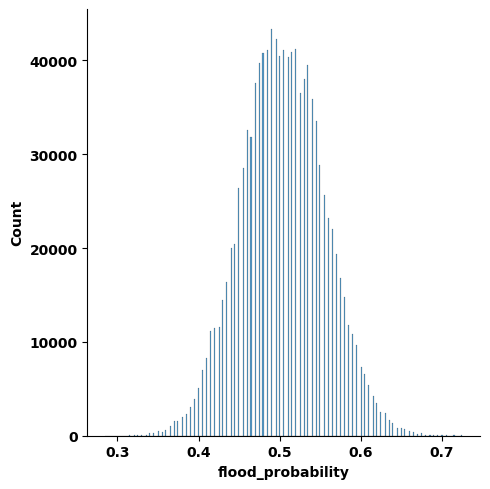

In [ ]:
sns.displot(df4['flood_probability'])

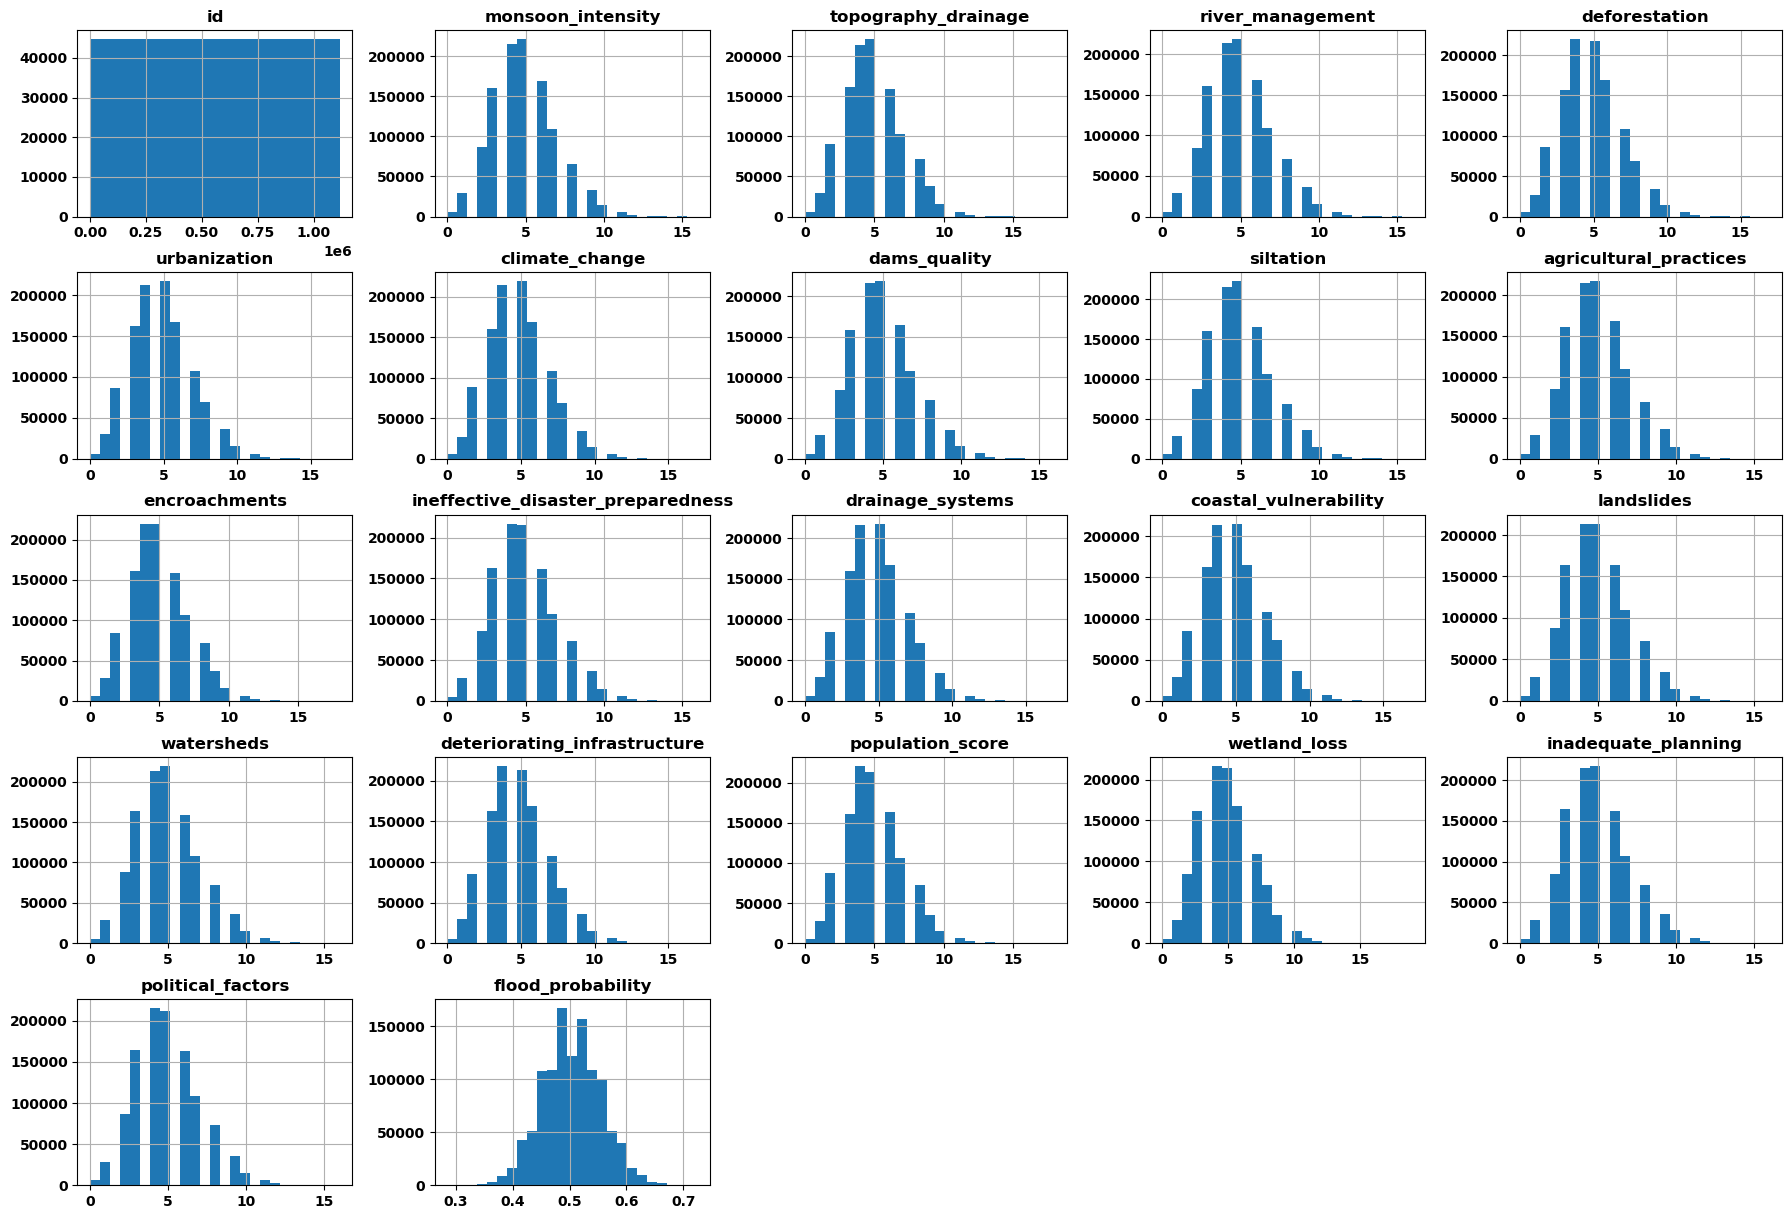

In [79]:
plt.style.use('default')
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist(bins=25, figsize=(22, 15));

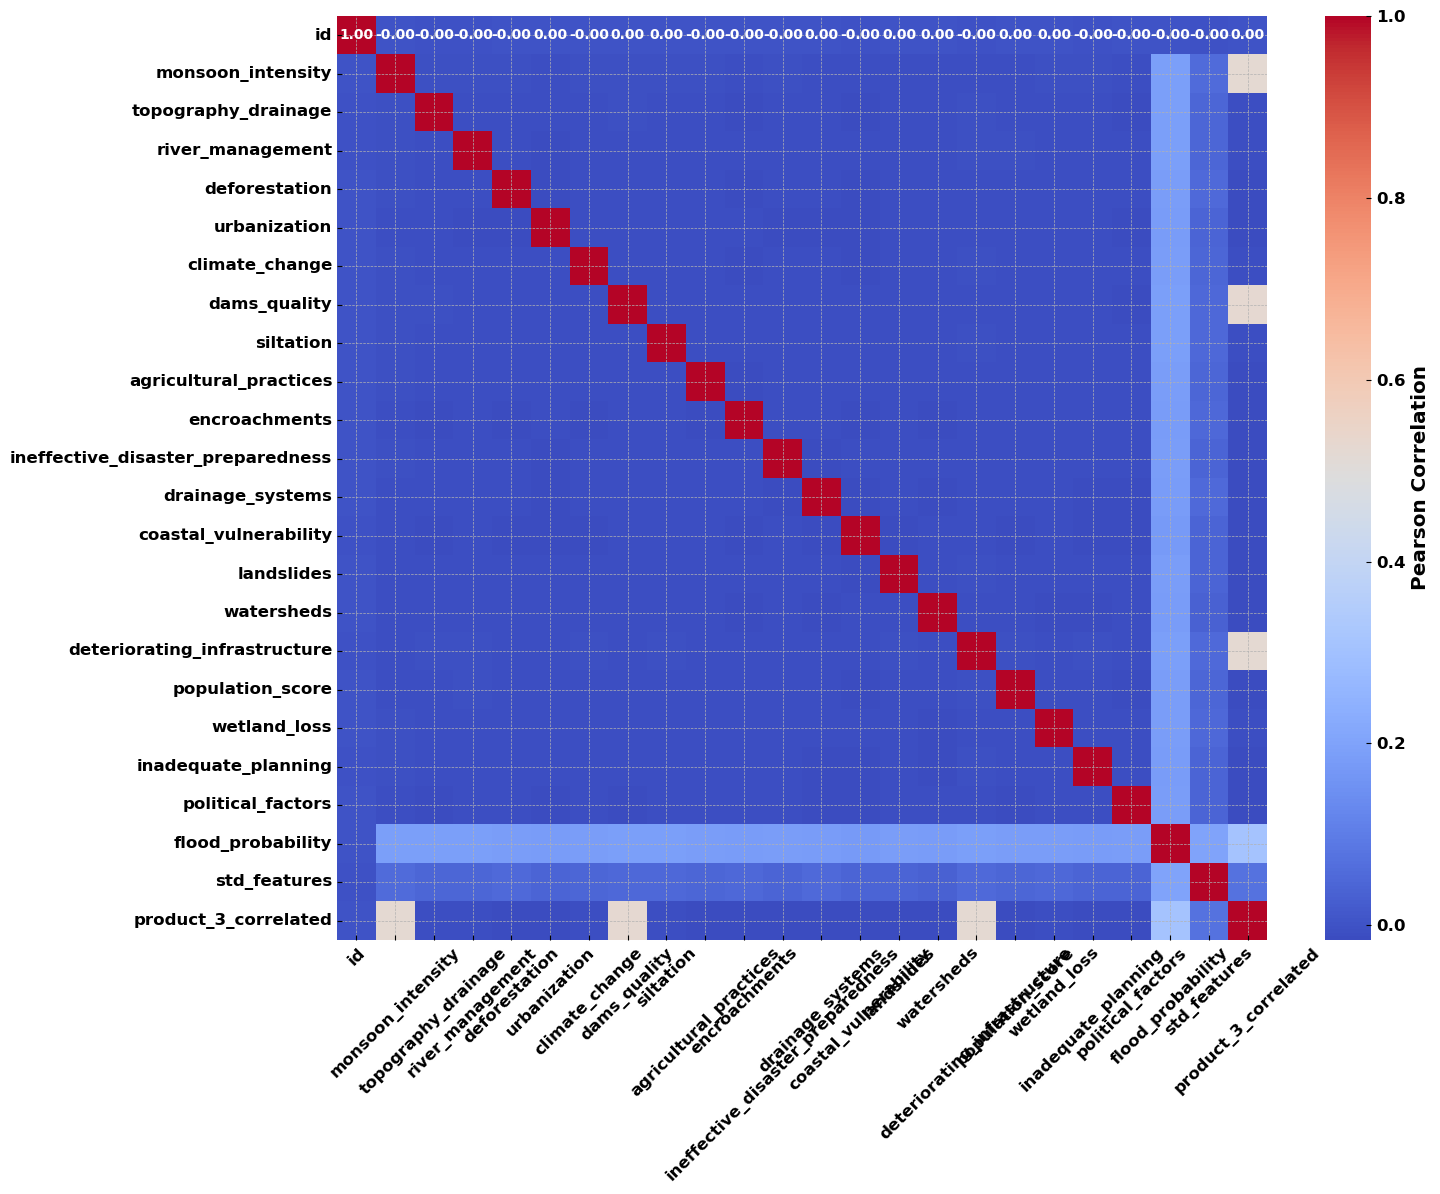

In [ ]:
correlacao = num_attributes.corr(method='pearson')
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'}, annot_kws={"size": 10})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.show()

# 5.0 Data Preparation

In [26]:
df5 = df4.copy()

In [27]:
x = df5.drop('flood_probability', axis=1)
y = df5['flood_probability'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [28]:
ss = pp.StandardScaler()
df5 = scale_standard(df5,['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors'],ss)

#,'std_features'

## 5.3 Validation Preparation

In [29]:
x_validation = scale_standard_test(x_validation,['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors'],ss)
   


In [30]:
x_train = df5.drop('flood_probability',axis=1)
y_train = df5['flood_probability']

In [31]:
x_train = x_train.drop('id',axis=1)
x_val = x_validation.drop('id',axis=1)

# 7.0 Machine Learning Modelling


## 7.1 RF

In [ ]:
# model definition
rf = en.RandomForestRegressor( n_estimators=90,max_depth=9, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict( x_val )

In [ ]:
yhat_rf

array([0.49923442, 0.50405823, 0.5232307 , ..., 0.5217587 , 0.50051708,
       0.51617158])

In [ ]:
r2 = r2_score(y_validation, yhat_rf)
r2

0.34184274745711574

## 7.2 CatBoost

In [42]:
#model and training1
model_catboost = CatBoostRegressor(loss_function='RMSE',
                                   iterations=100,
                                   learning_rate=0.35,
                                   depth=7,
                                   subsample=0.2,
                                   colsample_bylevel=0.6,
                                   verbose=85).fit(x_train, y_train)

#prediction
yhat_catboost = model_catboost.predict(x_val)

0:	learn: 0.0484247	total: 83.3ms	remaining: 8.25s
85:	learn: 0.0200882	total: 6.87s	remaining: 1.12s
99:	learn: 0.0200417	total: 7.83s	remaining: 0us


In [ ]:
import optuna

# Definir a função objetivo
def objective(trial):
    # Definir espaço de busca de hiperparâmetros
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0)
    }
    
    # Inicializar o modelo CatBoostRegressor com hiperparâmetros sugeridos
    model_catboost = CatBoostRegressor(loss_function='RMSE', verbose=0, **params)
    
    # Treinar o modelo
    model_catboost.fit(x_train, y_train)
    
    # Fazer previsões no conjunto de validação
    yhat_catboost = model_catboost.predict(x_val)
    
    # Calcular o coeficiente de determinação (R²)
    r2 = r2_score(y_validation, yhat_catboost)
    
    return r2

# Criar um estudo Optuna
study = optuna.create_study(direction='maximize')
# Executar a otimização
study.optimize(objective, n_trials=100)

# Melhores hiperparâmetros encontrados
best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

[I 2024-05-16 03:19:01,756] A new study created in memory with name: no-name-a150e832-2c6a-4580-aa39-376f5580b1b3
[I 2024-05-16 03:19:15,913] Trial 0 finished with value: 0.8436925468815051 and parameters: {'iterations': 107, 'learning_rate': 0.3449420314998446, 'depth': 10, 'subsample': 0.49891822728955537, 'colsample_bylevel': 0.7765830230121632}. Best is trial 0 with value: 0.8436925468815051.
[I 2024-05-16 03:20:03,842] Trial 1 finished with value: 0.8449633961180852 and parameters: {'iterations': 582, 'learning_rate': 0.4737927428118511, 'depth': 8, 'subsample': 0.48898540237753607, 'colsample_bylevel': 0.16453449511456097}. Best is trial 1 with value: 0.8449633961180852.
[I 2024-05-16 03:21:30,189] Trial 2 finished with value: 0.8455020030507667 and parameters: {'iterations': 934, 'learning_rate': 0.272838863682807, 'depth': 9, 'subsample': 0.36297234189463956, 'colsample_bylevel': 0.3702705788187718}. Best is trial 2 with value: 0.8455020030507667.
[I 2024-05-16 03:22:05,843] Tr

Melhores hiperparâmetros: {'iterations': 940, 'learning_rate': 0.1529307383364994, 'depth': 9, 'subsample': 0.7639334802870369, 'colsample_bylevel': 0.3794077649583697}


## 7.3 XGB

In [ ]:
import optuna

# Definir a função objetivo
def objective(trial):
    # Definir espaço de busca de hiperparâmetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 220, 450),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 4, 9),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'eta': trial.suggest_float('eta', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0)
    }
    
    # Inicializar o modelo CatBoostRegressor com hiperparâmetros sugeridos
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **params)
    
    # Treinar o modelo
    model_xgb.fit(x_train, y_train)
    
    # Fazer previsões no conjunto de validação
    yhat_xgb = model_xgb.predict(x_val)
    
    # Calcular o coeficiente de determinação (R²)
    r2 = r2_score(y_validation, yhat_xgb)
    
    return r2

# Criar um estudo Optuna
study = optuna.create_study(direction='maximize')
# Executar a otimização
study.optimize(objective, n_trials=35)

# Melhores hiperparâmetros encontrados
best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

c:\Users\rseme\anaconda3\envs\propensao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-16 16:11:41,401] A new study created in memory with name: no-name-e1a06507-3331-4c99-b582-6e4ee15e6efa
[I 2024-05-16 16:13:47,619] Trial 0 finished with value: 0.8168115736188838 and parameters: {'n_estimators': 322, 'learning_rate': 0.8694388375111509, 'max_depth': 5, 'subsample': 0.7693026931727261, 'eta': 0.3014683568829068, 'colsample_bytree': 0.5374056528036534}. Best is trial 0 with value: 0.8168115736188838.
[I 2024-05-16 16:38:07,061] Trial 1 finished with value: 0.8337093202973166 and parameters: {'n_estimators': 269, 'learning_rate': 0.6469788166137395, 'max_depth': 5, 'subsample': 0.1266893562804807, 'eta': 0.303210710530443, 'colsample_bytree': 0.1292776285239}. Best is trial 1 with value: 0.8337093202973

Melhores hiperparâmetros: {'n_estimators': 385, 'learning_rate': 0.9157470904384529, 'max_depth': 8, 'subsample': 0.8931006259342809, 'eta': 0.5911348648152464, 'colsample_bytree': 0.05120458050881028}


## 7.4 LGBM

In [ ]:
import optuna

# Definir a função objetivo
def objective(trial):
    # Definir espaço de busca de hiperparâmetros
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0)
    }
    
    # Inicializar o modelo CatBoostRegressor com hiperparâmetros sugeridos
    model_lgbm = LGBMRegressor(random_state=42, **params)
    
    # Treinar o modelo
    model_lgbm.fit(x_train, y_train)
    
    # Fazer previsões no conjunto de validação
    yhat_lgbm = model_lgbm.predict(x_val)
    
    # Calcular o coeficiente de determinação (R²)
    r2 = r2_score(y_validation, yhat_lgbm)
    
    return r2

# Criar um estudo Optuna
study = optuna.create_study(direction='maximize')
# Executar a otimização
study.optimize(objective, n_trials=22)

# Melhores hiperparâmetros encontrados
best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

In [40]:
r2 = r2_score(y_validation, yhat_catboost)
r2

0.846356158724609

## 7.5 Artificial Neural Network

In [ ]:
import tensorflow as tf

# Função para calcular o R²
def r2_metric(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

# Defina input_shape como o número de features nos seus dados de treinamento
input_shape = x_train.shape[1]

# Inicialização do modelo
model = Sequential()

# Adicionando camadas
model.add(Dense(512, activation='relu', input_shape=(input_shape,)))  # Camada de entrada
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear')) # Camada de saída para regressão linear

# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error',metrics=[r2_metric])

# Treinamento do modelo
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_validation))


Epoch 1/10
6988/6988 [==============================] - 41s 6ms/step - loss: 5.9305e-04 - r2_metric: 0.7618 - val_loss: 4.1223e-04 - val_r2_metric: 0.8385
Epoch 2/10
6988/6988 [==============================] - 40s 6ms/step - loss: 3.8351e-04 - r2_metric: 0.8495 - val_loss: 3.8051e-04 - val_r2_metric: 0.8512
Epoch 3/10
6988/6988 [==============================] - 40s 6ms/step - loss: 3.7479e-04 - r2_metric: 0.8527 - val_loss: 3.6561e-04 - val_r2_metric: 0.8569
Epoch 4/10
6988/6988 [==============================] - 39s 6ms/step - loss: 3.7173e-04 - r2_metric: 0.8540 - val_loss: 3.5775e-04 - val_r2_metric: 0.8599
Epoch 5/10
6988/6988 [==============================] - 40s 6ms/step - loss: 3.7077e-04 - r2_metric: 0.8543 - val_loss: 3.8251e-04 - val_r2_metric: 0.8503
Epoch 6/10
6988/6988 [==============================] - 41s 6ms/step - loss: 3.6941e-04 - r2_metric: 0.8549 - val_loss: 3.5931e-04 - val_r2_metric: 0.8593
Epoch 7/10
6988/6988 [==============================] - 41s 6ms/step -

In [ ]:
# Avaliação do modelo
y_val_pred = model.predict(x_val)
r2_val = r2_score(y_validation, y_val_pred)
print(f'R² Score (Validation): {r2_val}')

6988/6988 [==============================] - 12s 2ms/step
R² Score (Validation): 0.8621396390034584


512 e 10 epocs ate 32 - adam - 86,3
1024 e 9 epocs - adam - 86,31
512 e 9 epocs ate 16- adam - 86,35
512 e 11 ate 8 - 86,28
intercalando 512 ate 4 - 86,27
512 ate 4 normal e 9 epocs - 85,6

512 e 9 epocs ate 16- adam com lr 0.0001 - 85,51
512 e 9 epocs ate 16- adam com lr 0.0007 - 86,27
512 e 10 epocs ate 16- adam com lr 0.0009 - 86,36

# Ensemble - Catboost, XGB, LGBM with RF

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
import tensorflow as tf

# Função para calcular o R²
def r2_metric(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

# Defina input_shape como o número de features nos seus dados de treinamento
input_shape = x_train.shape[1]

# Inicialização do modelo
model = Sequential()

# Adicionando camadas
model.add(Dense(512, activation='relu', input_shape=(input_shape,)))  # Camada de entrada
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear')) # Camada de saída para regressão linear

# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error',metrics=[r2_metric])

# Treinamento do modelo
history = model.fit(x_train, y_train, batch_size=128, epochs=9, validation_data=(x_val, y_validation))

## Stacking com rede neural como estimador final

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Função para calcular o R²
def r2_metric(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

# Função para construir o modelo
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))  # Camada de entrada
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear')) # Camada de saída para regressão linear

    # Compilação do modelo
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=[r2_metric])
    return model

class TensorFlowWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, input_shape, epochs=10, batch_size=32, **fit_params):
        self.build_fn = build_fn
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.fit_params = fit_params
        self.model_ = None

    def fit(self, X, y):
        self.model_ = self.build_fn(self.input_shape)
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, **self.fit_params)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_metric(tf.convert_to_tensor(y, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32)).numpy()

# Definindo os modelos base
base_models = [
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=385,
                             eta=0.5911348648152464,
                             max_depth=8,
                             learning_rate=0.9157470904384529,
                             subsample=0.8931006259342809,
                             colsample_bytree=0.05120458050881028,
                             random_state=42)),
    ('catboost', CatBoostRegressor(loss_function='RMSE',
                                   iterations=940,
                                   learning_rate=0.1529307383364994,
                                   depth=9,
                                   subsample=0.7639334802870369,
                                   colsample_bylevel=0.3794077649583697,
                                   random_state=42,
                                   verbose=85)),
    ('lgbm', LGBMRegressor(subsample=0.9943329883689916,
                           reg_lambda=0.6958774095700068,
                           reg_alpha=0.821918691281162,
                           num_leaves=38,
                           n_estimators=452,
                           min_child_samples=34,
                           max_depth=4,
                           learning_rate=0.3272881448742752,
                           colsample_bytree=0.05033175690616236,
                           random_state=42))
]

# Obter o número de saídas dos estimadores base (quantidade de previsões)
base_output_shape = len(base_models) + x_train.shape[1]  # Cada modelo base produz 1 previsão mais as características originais

# Criar o StackingRegressor com TensorFlowWrapper como estimador final
stacking_regressor_pt = StackingRegressor(
    estimators=base_models,
    final_estimator=TensorFlowWrapper(
        build_fn=build_model,
        input_shape=base_output_shape,
        epochs=10,
        batch_size=128,
        validation_data=(x_val, y_validation)
    ),
    passthrough=True
)

# Treinar o modelo de stacking
stacking_regressor_pt.fit(x_train, y_train)

# Avaliar o modelo
y_pred_stacking_pt = stacking_regressor_pt.predict(x_val)
r2_score_stacking_pt = r2_score(y_validation, y_pred_stacking_pt)
r2_score_stacking_pt = round(r2_score_stacking_pt, 5)



In [ ]:
print("R² Stacking - passthrough: {:.5f}".format(r2_score_stacking_pt))

R² Stacking - passthrough: 0.85957


## Stacking sem rede neural 

In [ ]:
# Definir os modelos base
base_models = [
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=385,
                             eta=0.5911348648152464,
                             max_depth=8,
                             learning_rate=0.9157470904384529,
                             subsample=0.8931006259342809,
                             colsample_bytree=0.05120458050881028,
                            random_state=42)),
    ('catboost', CatBoostRegressor(loss_function='RMSE',
                                   iterations=940,
                                   learning_rate=0.1529307383364994,
                                   depth=9,
                                   subsample=0.7639334802870369,
                                   colsample_bylevel=0.3794077649583697,
                                   random_state=42,
                                   verbose=85)),
    ('lgbm', LGBMRegressor(subsample=0.9943329883689916,
                           reg_lambda=0.6958774095700068,
                           reg_alpha=0.821918691281162,
                           num_leaves=38,
                           n_estimators=452,
                           min_child_samples=34,
                           max_depth=4,
                           learning_rate=0.3272881448742752,
                           colsample_bytree=0.05033175690616236,
                           random_state=42 ))]

# Criar o StackingRegressor

stacking_regressor_pt = StackingRegressor(estimators=base_models, final_estimator=RandomForestRegressor(random_state=42), passthrough = True)
stacking_regressor_pt.fit(x_train, y_train)

# Avaliar os modelos
y_pred_stacking_pt = stacking_regressor_pt.predict(x_val)


r2_score_stacking_pt = r2_score(y_validation, y_pred_stacking_pt)
r2_score_stacking_pt = round(r2_score_stacking_pt, 5)



## stacking com rede neural como estimador base

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Função para calcular o R²
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

# Classe TensorFlowWrapper
class TensorFlowWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn=None, input_shape=None, epochs=10, batch_size=32, validation_data=None, **kwargs):
        self.build_fn = build_fn
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_data = validation_data
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn(self.input_shape, **self.kwargs)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_data=self.validation_data, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Função para construir o modelo da rede neural
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=[r2_metric])
    return model

# Definir os modelos base
input_shape = x_train.shape[1]  # Certifique-se de que x_train esteja definido corretamente antes desta linha

base_models = [
   # ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
             #                n_estimators=385,
               #              eta=0.5911348648152464,
                 #            max_depth=8,
                   #          learning_rate=0.9157470904384529,
                    #         subsample=0.8931006259342809,
                     #        colsample_bytree=0.05120458050881028,
                      #       random_state=42)),
    ('catboost', CatBoostRegressor(loss_function='RMSE',
                                iterations=940,
                                learning_rate=0.1529307383364994,
                                depth=9,
                                subsample=0.7639334802870369,
                                colsample_bylevel=0.3794077649583697,
                                random_state=42,
                                verbose=85)),
    ('lgbm', LGBMRegressor(subsample=0.9943329883689916,
                           reg_lambda=0.6958774095700068,
                           reg_alpha=0.821918691281162,
                           num_leaves=38,
                           n_estimators=452,
                           min_child_samples=34,
                           max_depth=4,
                           learning_rate=0.3272881448742752,
                           colsample_bytree=0.05033175690616236,
                         random_state=42)),
    ('ann', TensorFlowWrapper(build_fn=build_model, input_shape=input_shape))  # Remova validation_data aqui
]

# Criar o StackingRegressor com RandomForestRegressor como estimador final
stacking_regressor_pt = StackingRegressor(
    estimators=base_models,
    final_estimator=RandomForestRegressor(random_state=42),
    passthrough=True
)

# Treinar o modelo de stacking
stacking_regressor_pt.fit(x_train, y_train)

# Avaliar o modelo
y_pred_stacking_pt = stacking_regressor_pt.predict(x_val)
r2_score_stacking_pt = r2_score(y_validation, y_pred_stacking_pt)
r2_score_stacking_pt = round(r2_score_stacking_pt, 5)

print("R² Score:", r2_score_stacking_pt)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
y_pred_stacking_pt_kaggle = stacking_regressor_pt.predict(x_test)

23291/23291 [==============================] - 54s 2ms/step


In [ ]:
y_pred_stacking_pt_kaggle

array([0.58   , 0.45685, 0.4534 , ..., 0.6192 , 0.5506 , 0.5293 ])

# Final Model

## Train Preparation

In [46]:
ss = pp.StandardScaler()
x = scale_standard(x,['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors'],ss)


## Test Preparation

In [48]:
df_test = d_test.copy()

In [49]:
cols_old = ['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df_test.columns = cols_new
df_test.columns = df_test.columns.str.replace(' ', '_')

In [51]:
df_test = scale_standard_test(df_test,['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors'],ss)
   
#df_test = rescaling_mms_test(df_test,['product_3_correlated',],mms)


In [53]:
x_test = df_test.drop('id',axis=1)


In [54]:
x = x.drop('id',axis=1)


In [58]:
yhat_catboost_ok.shape

(745305,)

In [67]:
# Contar quantos valores são maiores que 0.68
num_values_greater_than_068 = np.sum(yhat_catboost_ok > 0.67)

print(f"Number of values greater than 0.68: {num_values_greater_than_068}")

Number of values greater than 0.68: 585


In [ ]:
# Definir os modelos base
base_models = [
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=385,
                             eta=0.5911348648152464,
                             max_depth=8,
                             learning_rate=0.9157470904384529,
                             subsample=0.8931006259342809,
                             colsample_bytree=0.05120458050881028,
                            random_state=42)),
    ('catboost', CatBoostRegressor(loss_function='RMSE',
                                   iterations=940,
                                   learning_rate=0.1529307383364994,
                                   depth=9,
                                   subsample=0.7639334802870369,
                                   colsample_bylevel=0.3794077649583697,
                                   random_state=42,
                                   verbose=85)),
    ('lgbm', LGBMRegressor(subsample=0.9943329883689916,
                           reg_lambda=0.6958774095700068,
                           reg_alpha=0.821918691281162,
                           num_leaves=38,
                           n_estimators=452,
                           min_child_samples=34,
                           max_depth=4,
                           learning_rate=0.3272881448742752,
                           colsample_bytree=0.05033175690616236,
                           random_state=42 ))]

# Criar o StackingRegressor

stacking_regressor_pt = StackingRegressor(estimators=base_models, final_estimator=RandomForestRegressor(random_state=42), passthrough = True)
stacking_regressor_pt.fit(x, y)

# Avaliar os modelos
yhat_ensemble_max = stacking_regressor_pt.predict(x_test)





0:	learn: 0.0494011	total: 326ms	remaining: 5m 5s
85:	learn: 0.0209667	total: 15.1s	remaining: 2m 30s
170:	learn: 0.0200069	total: 28.6s	remaining: 2m 8s
255:	learn: 0.0198887	total: 42.8s	remaining: 1m 54s
340:	learn: 0.0198093	total: 56.4s	remaining: 1m 39s
425:	learn: 0.0197244	total: 1m 9s	remaining: 1m 24s
510:	learn: 0.0196374	total: 1m 23s	remaining: 1m 10s
595:	learn: 0.0195581	total: 1m 37s	remaining: 56.2s
680:	learn: 0.0194830	total: 1m 51s	remaining: 42.3s
765:	learn: 0.0194126	total: 2m 4s	remaining: 28.3s
850:	learn: 0.0193404	total: 2m 18s	remaining: 14.4s
935:	learn: 0.0192755	total: 2m 31s	remaining: 649ms
939:	learn: 0.0192730	total: 2m 32s	remaining: 0us
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1

KeyboardInterrupt: 

In [ ]:
# Avaliação do modelo
yhat_redeneural_final = rn.predict(x_test)


23291/23291 [==============================] - 50s 2ms/step


In [ ]:
yhat_ensemble_max

NameError: name 'yhat_ensemble_max' is not defined

In [ ]:
yhat_redeneural_final_v2 = rn2.predict(x_test)

23291/23291 [==============================] - 54s 2ms/step


In [ ]:
d = df_test.copy()

In [ ]:
d['FloodProbability'] = yhat_ensemble_max

In [ ]:
submission = d.loc[:,['id','FloodProbability']]

In [ ]:
caminho_arquivo_csv = 's24.csv'

submission.to_csv(caminho_arquivo_csv, index=False)

In [ ]:
y_pred_stacking_pt_kaggle

array([0.57905, 0.4539 , 0.4553 , ..., 0.62245, 0.5477 , 0.5303 ])

In [ ]:
caminho_arquivo_csv = 's26.csv'

s25.to_csv(caminho_arquivo_csv, index=False)